# Solution of Linear PDEs in High Dimensions : Option Pricing


## Solution Method
The approach relies on

1. the generation of training data by generating sample paths of the stochastic process $\{X_t\}_{t \in [0,T]}$ 
2. a neural network approximation of the unknown function $u(T,x) \approx u_\theta(x)$.

### Step 2: Neural network approximation


In [1]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation, Input
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import Callback
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
from sklearn.metrics import r2_score
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
# Set data type
DTYPE='float32'
#DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)
print('TensorFlow version used: {}'.format(tf.__version__))



TensorFlow version used: 2.13.0


Next, we set some problem specific data.

In [12]:
# Final time
T = tf.constant(1., dtype=DTYPE)

# Spatial dimensions
dim = 100

# Domain-of-interest at t=0
a = 90 * tf.ones((dim), dtype=DTYPE)
b = 110 * tf.ones((dim), dtype=DTYPE)

# Interest rate
r = tf.constant(1./20, dtype=DTYPE)

# Drift
mu = tf.constant(-1./20, dtype=DTYPE)

# Strike price
K = tf.constant(100., dtype=DTYPE)

# Diffusion/volatility
sigma = 1./10 + 1./200*tf.range(1, dim+1, dtype=DTYPE)

# Define terminal condition, i.e., payoff at maturity
def fun_g(x):
    return tf.exp(-r * T) * tf.maximum(tf.reduce_max(x, axis=1, keepdims=True), K)

In [61]:
def init_model(dim, activation='relu',
               num_hidden_neurons=200,
               num_hidden_layers=2,
               initializer=GlorotUniform()):
    model = Sequential()
    model.add(Input(shape=(dim,)))
    model.add(BatchNormalization(epsilon=1e-6))

    # Create a fixed number of hidden layers
    for _ in range(num_hidden_layers):
        model.add(Dense(num_hidden_neurons,
                        activation=None,
                        use_bias=False,
                        kernel_initializer=initializer))
        model.add(BatchNormalization(epsilon=1e-6))
        model.add(Activation(activation))

    model.add(Dense(1,
                    activation=None,
                    use_bias=False,
                    kernel_initializer=initializer))
    model.add(BatchNormalization(epsilon=1e-6))
    return model

### 5. Solve the PDE




The model provided above uses a feed-forward neural network (FFNN) to approximate the solution of the Black-Scholes equation. Here's a high-level overview of how the model works:

1. **Input:** The input to the model is a set of starting values for the stochastic process X, which represents the underlying asset price in the Black-Scholes equation. These starting values are drawn randomly from a specified domain.

2. **Forward Pass:** The input is passed through the neural network model, which consists of multiple hidden layers with nonlinear activation functions. Each hidden layer applies a linear transformation to the input followed by the activation function.

3. **Output:** The output layer of the neural network produces a single scalar value, which represents the predicted price of the derivative based on the given input.

4. **Loss Function:** The model's predicted price is compared to the true price of the derivative using a loss function. In the provided code, the loss function is not explicitly defined, but it is likely a measure of the difference between the predicted price and the true price. The goal of training is to minimize this loss.

5. **Training:** The model is trained using a gradient-based optimization algorithm, such as the Adam optimizer, to update the weights and biases of the neural network. This optimization process iteratively adjusts the model's parameters to minimize the loss function.

6. **Evaluation:** After training, the model can be used to approximate the solution of the Black-Scholes equation for unseen inputs. The trained model takes the starting values as input and produces the predicted derivative price as output.

By learning the underlying patterns and relationships in the training data, the neural network model can approximate the solution of the Black-Scholes equation and provide predictions for derivative prices based on new inputs.

In [13]:
#Euler
def draw_X(num_samples, a, b):
    dim = a.shape[0]

    X0 = a + tf.random.uniform((num_samples, dim), dtype=DTYPE) * (b-a)
    xi = tf.random.normal(shape=(num_samples, dim), dtype=DTYPE)
    XT = X0 * tf.exp( (mu- tf.square(sigma)/2) * T + sigma * tf.sqrt(T) * xi)

    # Return simulated paths
    return tf.stack([X0, XT], 2)

In [14]:
n_test = 80000
X = draw_X(n_test, a, b)
Xtest = X[:, :, 0]
Xtest = tf.convert_to_tensor(Xtest, dtype=DTYPE)
Y = tf.zeros((Xtest.shape[0], 1), dtype=DTYPE)  # Create an initial Ytest tensor filled with zeros
b_size = 32
mc_samples = 4000

def mc_step(y):

    Xi = tf.random.normal(shape=(b_size, dim), dtype=DTYPE)
    upd = tf.exp((mu - tf.square(sigma) / 2) * T + sigma * tf.sqrt(T) * Xi)
    XT = tf.reshape(Xtest, shape=[n_test, dim, 1]) * tf.transpose(upd)
    expected_payoff = tf.reduce_sum(tf.reshape(fun_g(XT), [n_test, b_size]), axis=1, keepdims=True)
    return y + expected_payoff / (b_size * mc_samples)


for i in range(mc_samples):
    if i%100==0:
        print(i,'/',mc_samples)
    Y=mc_step(Y)

0 / 4000
100 / 4000
200 / 4000
300 / 4000
400 / 4000
500 / 4000
600 / 4000
700 / 4000
800 / 4000
900 / 4000
1000 / 4000
1100 / 4000
1200 / 4000
1300 / 4000
1400 / 4000
1500 / 4000
1600 / 4000
1700 / 4000
1800 / 4000
1900 / 4000
2000 / 4000
2100 / 4000
2200 / 4000
2300 / 4000
2400 / 4000
2500 / 4000
2600 / 4000
2700 / 4000
2800 / 4000
2900 / 4000
3000 / 4000
3100 / 4000
3200 / 4000
3300 / 4000
3400 / 4000
3500 / 4000
3600 / 4000
3700 / 4000
3800 / 4000
3900 / 4000


In [28]:
np.mean(Y)

253.07613

In [69]:
Ytest = np.array(Y)
df = pd.DataFrame(Xtest)
df['Y'] = Ytest
X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop(columns=['Y']), df.loc[:, 'Y'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [89]:
# Define the model
model = init_model(dim=dim)

# Learning rate schedule and optimizer
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([100, 200], [2e-3, 1e-6, 1e-8])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)


# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_96 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_72 (Dense)            (None, 200)               20000     
                                                                 
 batch_normalization_97 (Ba  (None, 200)               800       
 tchNormalization)                                               
                                                                 
 activation_48 (Activation)  (None, 200)               0         
                                                                 
 dense_73 (Dense)            (None, 200)               40000     
                                                                 
 batch_normalization_98 (Ba  (None, 200)             

c:\Users\pc\anaconda3\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [90]:
class CustomCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.train_losses = []
        self.val_losses = []
        self.predictions = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

        # Save the losses
        self.train_losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])

        # Assuming we want to make and save predictions on the validation data
        predictions = self.model.predict(X_val).flatten()
        self.predictions.append(predictions[-1])  # Save the last prediction

# Initialize the callback
custom_callback = CustomCallback()

In [91]:
# Fit the model with the custom callback
start_time = time.time()
history = model.fit(
    X_train, 
    y_train, 
    batch_size=128, 
    epochs=500,  # Make sure this is the desired number of epochs
    validation_data=(X_val, y_val), 
    callbacks=[custom_callback]  # Corrected here
)
end_time = time.time()
total_time = end_time - start_time


Epoch 1/500
63/63 [==============================] - 2s 20ms/step - loss: 17611.1543 - val_loss: 59701.8242
Epoch 2/500
63/63 [==============================] - 1s 17ms/step - loss: 5.4826 - val_loss: 10564.7998
Epoch 3/500
63/63 [==============================] - 1s 18ms/step - loss: 1.9545 - val_loss: 2284.1389
Epoch 4/500
63/63 [==============================] - 1s 18ms/step - loss: 1.9262 - val_loss: 588.7164
Epoch 5/500
63/63 [==============================] - 1s 17ms/step - loss: 1.9269 - val_loss: 164.2027
Epoch 6/500
63/63 [==============================] - 1s 17ms/step - loss: 1.9203 - val_loss: 50.1866
Epoch 7/500
63/63 [==============================] - 1s 18ms/step - loss: 1.9162 - val_loss: 17.9436
Epoch 8/500
63/63 [==============================] - 1s 18ms/step - loss: 1.9069 - val_loss: 7.9604
Epoch 9/500
63/63 [==============================] - 1s 22ms/step - loss: 1.9025 - val_loss: 4.4743
Epoch 10/500
63/63 [==============================] - 1s 15ms/step - loss: 1.91

In [14]:
# After training, create a DataFrame with the logged data
results_df = pd.DataFrame({
    'Epoch': range(1, len(custom_callback.train_losses) + 1),
    'Training_Loss': custom_callback.train_losses,
    'Validation_Loss': custom_callback.val_losses,
    'Epoch_Run_Time(s)': custom_callback.epoch_times,
    'Last_Prediction': custom_callback.predictions
})

# Save the DataFrame to a CSV file
results_df.to_csv('model_performance.csv', index=False)

In [11]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from sklearn.metrics import mean_absolute_error
# Assuming you have already trained your model and obtained predictions for both validation and test data
y_pred_val = model.predict(X_val)  # Predictions for validation data
y_pred_test = model.predict(X_test)  # Predictions for test data
y_pred_train = model.predict(X_train)  # Predictions for training data


# Calculate R-squared for both sets
r_squared_val = r2_score(y_val, y_pred_val)
r_squared_test = r2_score(y_test, y_pred_test)
r_squared_train = r2_score(y_train, y_pred_train)


# Calculate MAE for all three datasets
mae_val = mean_absolute_error(y_val, y_pred_val)
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Calculate MSE for all three datasets
mse_val = mean_squared_error(y_val, y_pred_val)
mse_test = mean_squared_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)



print(f"Accuracy on Validation Data: {r_squared_val * 100}")
print(f"Accuracy on Test Data: {r_squared_test * 100}")
print(f"Accuracy on Train Data: {r_squared_test * 100}")

print(f"Mean Absolute Error (MAE) on Validation Data: {mae_val:.4f}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae_test:.4f}")
print(f"Mean Absolute Error (MAE) on Training Data: {mae_train:.4f}")

print(f"Mean Squared Error (MSE) on Validation Data: {mse_val:.4f}")
print(f"Mean Squared Error (MSE) on Test Data: {mse_test:.4f}")
print(f"Mean Squared Error (MSE) on Training Data: {mse_train:.4f}")

1225/1225 [==============================] - 2s 1ms/step
Accuracy on Validation Data: 99.29509713686546
Accuracy on Test Data: 99.28769351170854
Accuracy on Train Data: 99.28769351170854
Mean Absolute Error (MAE) on Validation Data: 0.1471
Mean Absolute Error (MAE) on Test Data: 0.1478
Mean Absolute Error (MAE) on Training Data: 0.1283
Mean Squared Error (MSE) on Validation Data: 0.0341
Mean Squared Error (MSE) on Test Data: 0.0344
Mean Squared Error (MSE) on Training Data: 0.0259


C:\Users\pc\AppData\Local\Temp\ipykernel_16272\3557489013.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


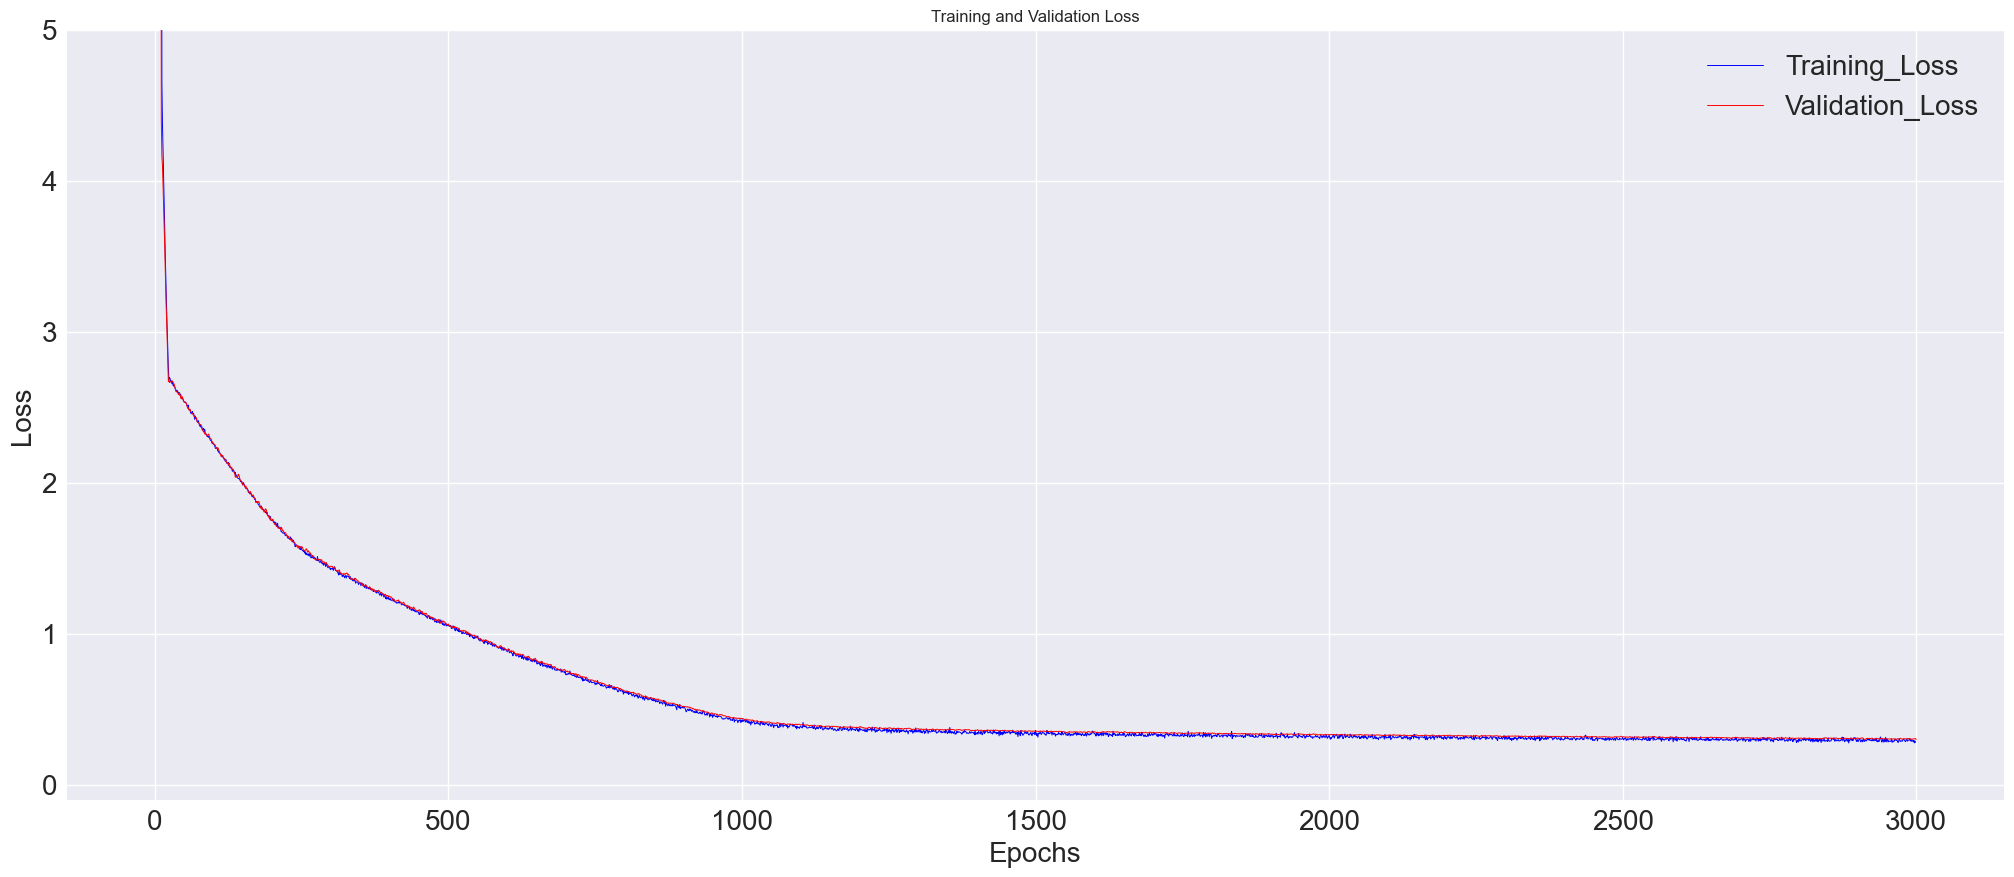

In [11]:

performance = pd.read_csv("model_performance_GBM.csv")
# Create a subplot grid with two subplots side by side
plt.figure(figsize=(25, 10))

# Plot the blue line for "Approximation" and the horizontal line for "Exact Solution" on the first subplot
plt.plot(performance['Training_Loss'], color = 'b',label="Training_Loss", linewidth=0.7)
plt.plot(performance['Validation_Loss'], color = 'r',label="Validation_Loss", linewidth=0.7)

plt.xlabel('Epochs',fontsize="20")
plt.ylabel('Loss',fontsize="20")
plt.title('Training and Validation Loss')
plt.xticks(size = 20)
plt.yticks(size = 20)


# Customize the plot style
plt.style.use("seaborn")
plt.ylim(-0.1,5)
# plt.savefig("training_loss_plot_multi assets.jpg", format="jpeg", dpi = 500)
plt.legend(fontsize="20")
# Show the combined plot
plt.show()

C:\Users\pc\AppData\Local\Temp\ipykernel_16272\2826642762.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


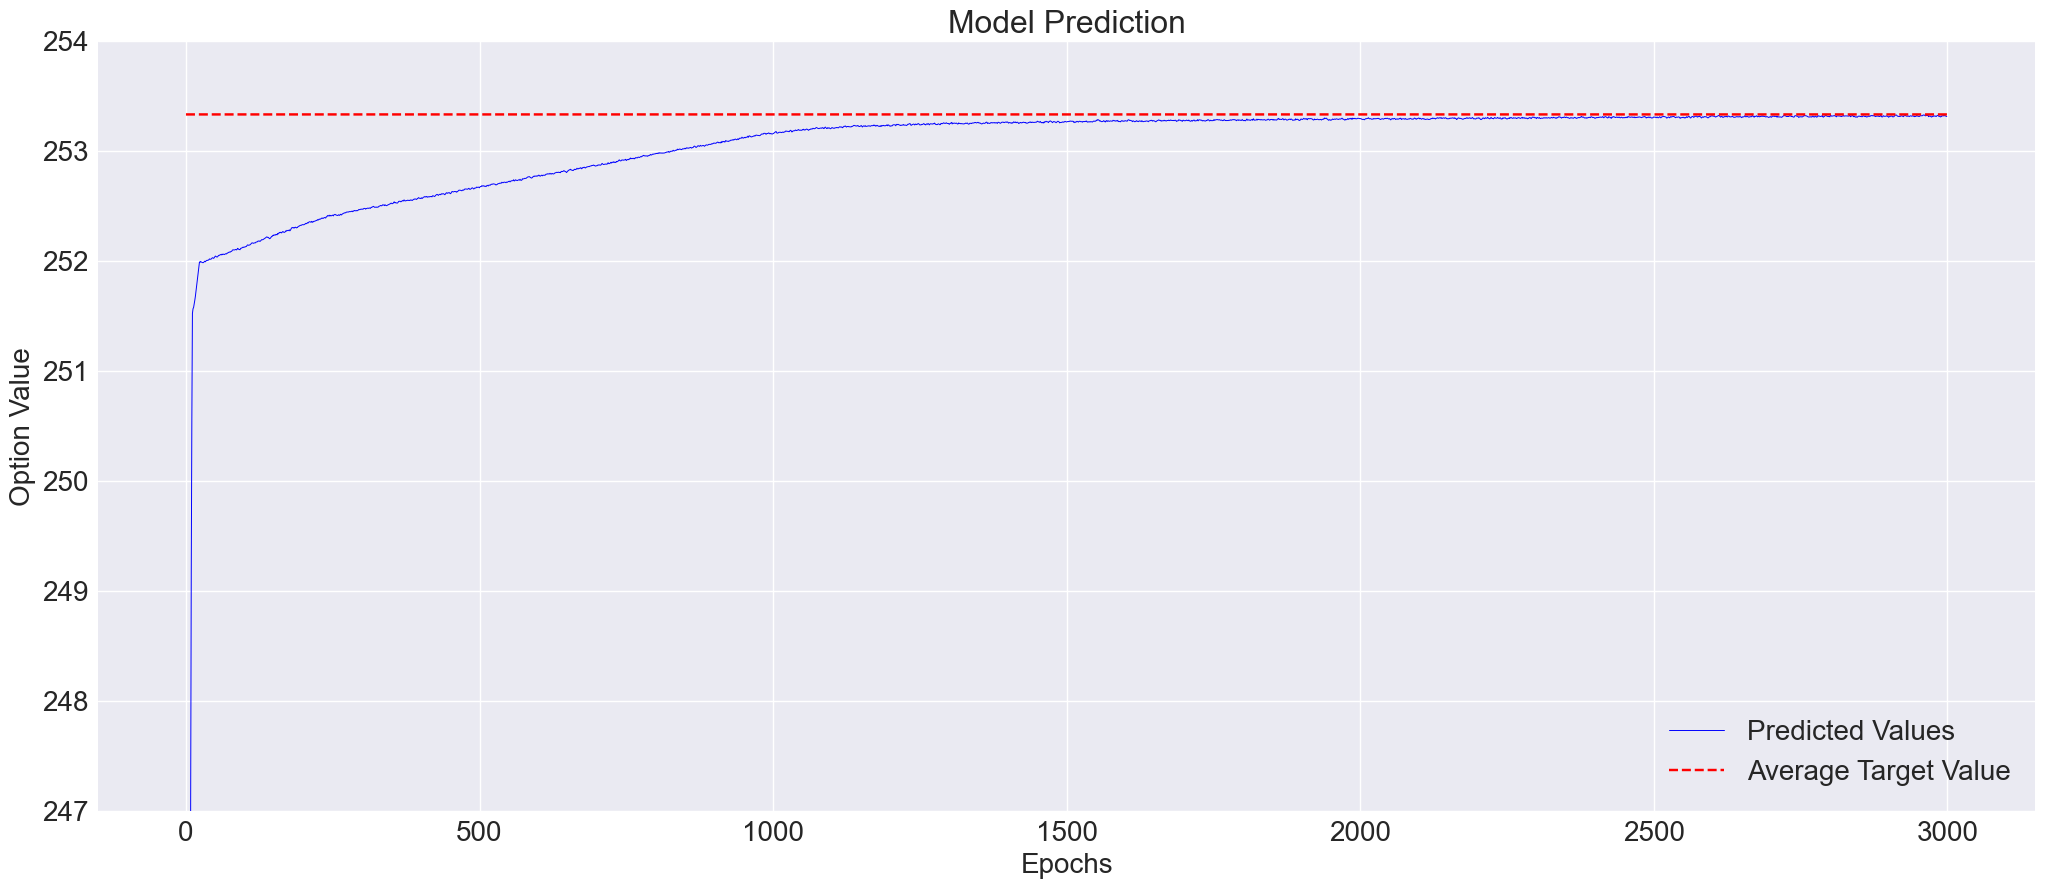

In [12]:
plt.figure(figsize=(25, 10))
plt.plot(performance['Predicted_Values'], color = 'b',label="Predicted Values", linewidth=0.7)
# Create an array of the same length as the number of epochs for plotting the average target value
average_target_value_line = np.full_like(performance['Predicted_Values'], 253.33)
plt.plot(average_target_value_line, linestyle='--', color='red', label='Average Target Value')
plt.ylim(247,254)
plt.xlabel('Epochs',fontsize="20")
plt.ylabel('Option Value',fontsize="20")
plt.title('Model Prediction',fontsize="23")
plt.xticks(size = 20)
plt.yticks(size = 20)


# Customize the plot style
plt.style.use("seaborn")
plt.legend(fontsize="20")
plt.savefig("solution GBM.jpg", format="jpeg", dpi = 500)
# Show the combined plot
plt.show()


